In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# OpenMP

In [2]:
N_EPOCHS = 1000

df = pd.read_csv('../benchmarks/results_cpu_all_omp_static.csv')
df['n_organisms'] = df['grid_width'] * df['grid_height']
df['time_per_epoch'] = df['time'] / N_EPOCHS
df

,n_threads,grid_width,grid_height,mutation_rate,genome_size,time,n_organisms,time_per_epoch
0,8,32,32,0.000100,500,134295,1024,134.295
1,8,32,32,0.000010,500,103040,1024,103.040
2,8,32,32,0.000001,500,102114,1024,102.114
3,8,128,128,0.000100,500,1463354,16384,1463.354
4,8,128,128,0.000010,500,853253,16384,853.253
...,...,...,...,...,...,...,...,...
1315,6,32,32,0.000001,50000,855800,1024,855.800
1316,6,128,128,0.000100,50000,289391612,16384,289391.612
1317,6,128,128,0.000010,50000,68006495,16384,68006.495
1318,6,128,128,0.000001,50000,12384768,16384,12384.768


## Computing speedup

There definitely is a less stupid way of doing this

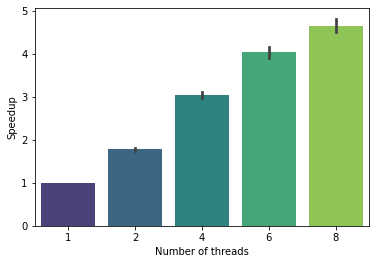

In [3]:
for n_organisms in df['n_organisms'].unique():
    for mutation_rate in df['mutation_rate'].unique():
        for genome_size in df['genome_size'].unique():
            baseline = df[(df['n_threads'] == 1) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time'].mean()
            for n_threads in df['n_threads'].unique():
                df.loc[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size), 'speedup'] = baseline / df[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time']


ax = sns.barplot(data=df, x='n_threads', y='speedup', palette="viridis")
ax.set_xlabel("Number of threads")
ax.set_ylabel("Speedup")
ax.get_figure().savefig('img/speedup.pdf')

## Graphing mean time per epoch

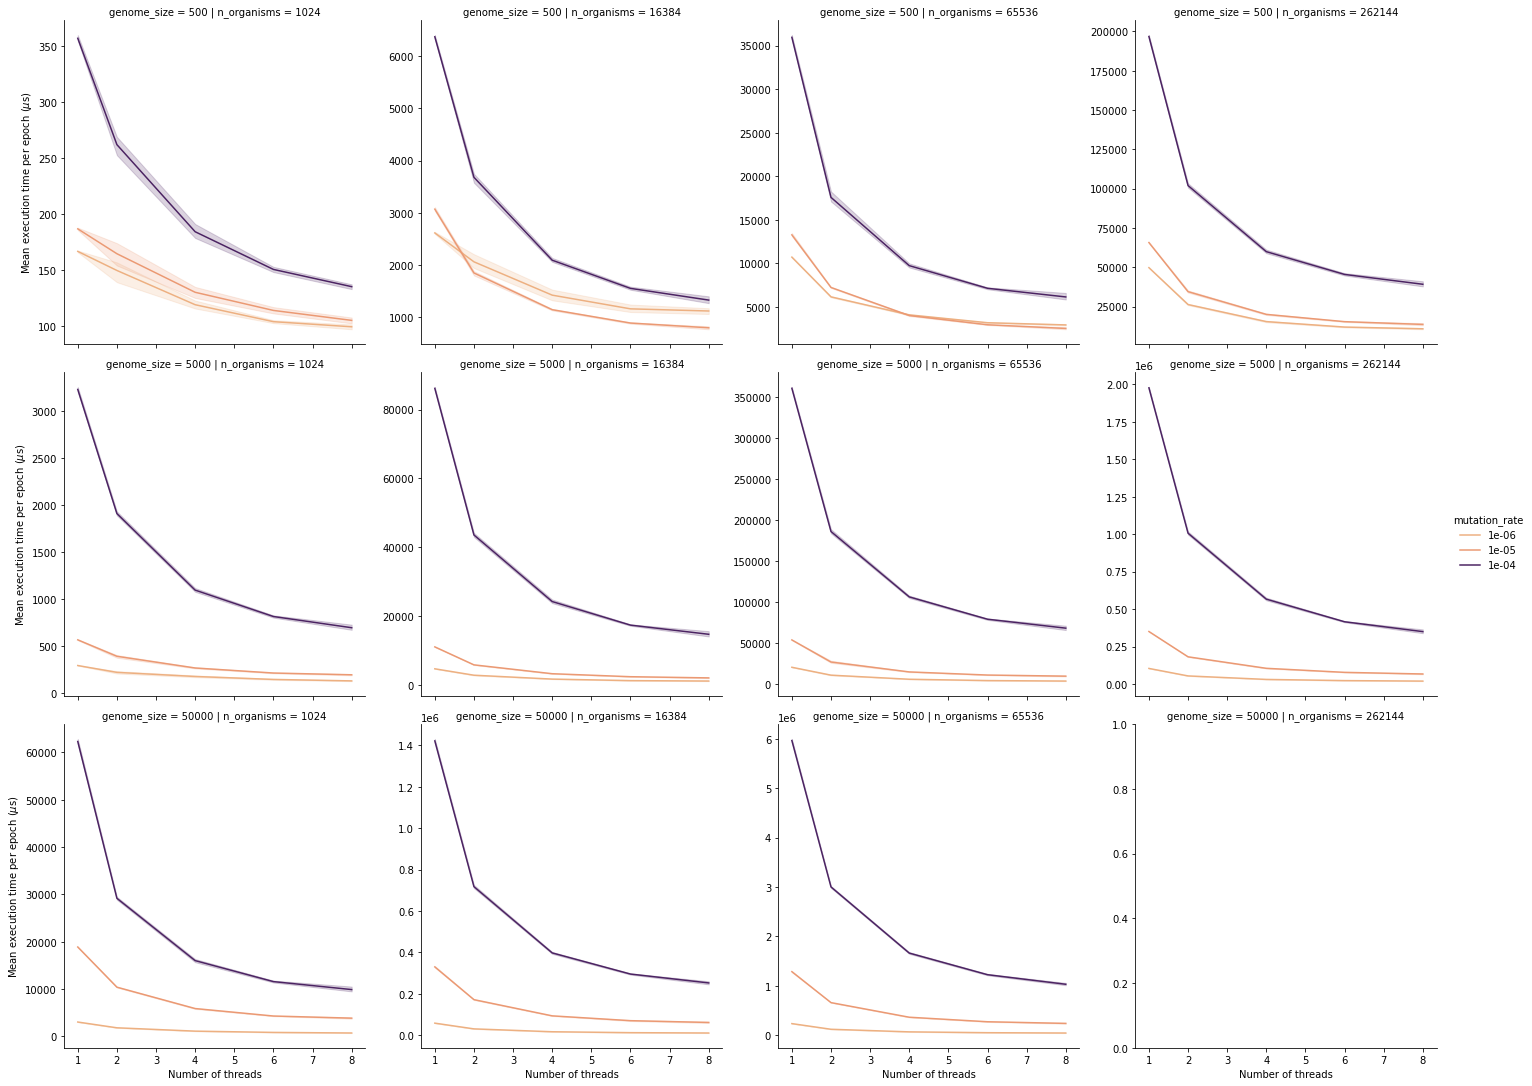

In [4]:
df_no_swp = df[(df['n_organisms'] != 512*512) | (df['genome_size'] != 50000)]
fig = sns.relplot(data=df_no_swp, x="n_threads", y="time_per_epoch", hue="mutation_rate", col="n_organisms", kind="line", row="genome_size", legend="full", facet_kws={'sharey': False}, palette='flare')
fig.set_xlabels("Number of threads")
fig.set_ylabels("Mean execution time per epoch ($\mu$s)")

# fix mix of scientific and decimal notation 
for legend in fig._legend.texts:
    legend.set_text( f'{float(legend.get_text()):.0e}')

plt.show(fig)
fig.savefig('img/benchmark_omp_static.pdf')

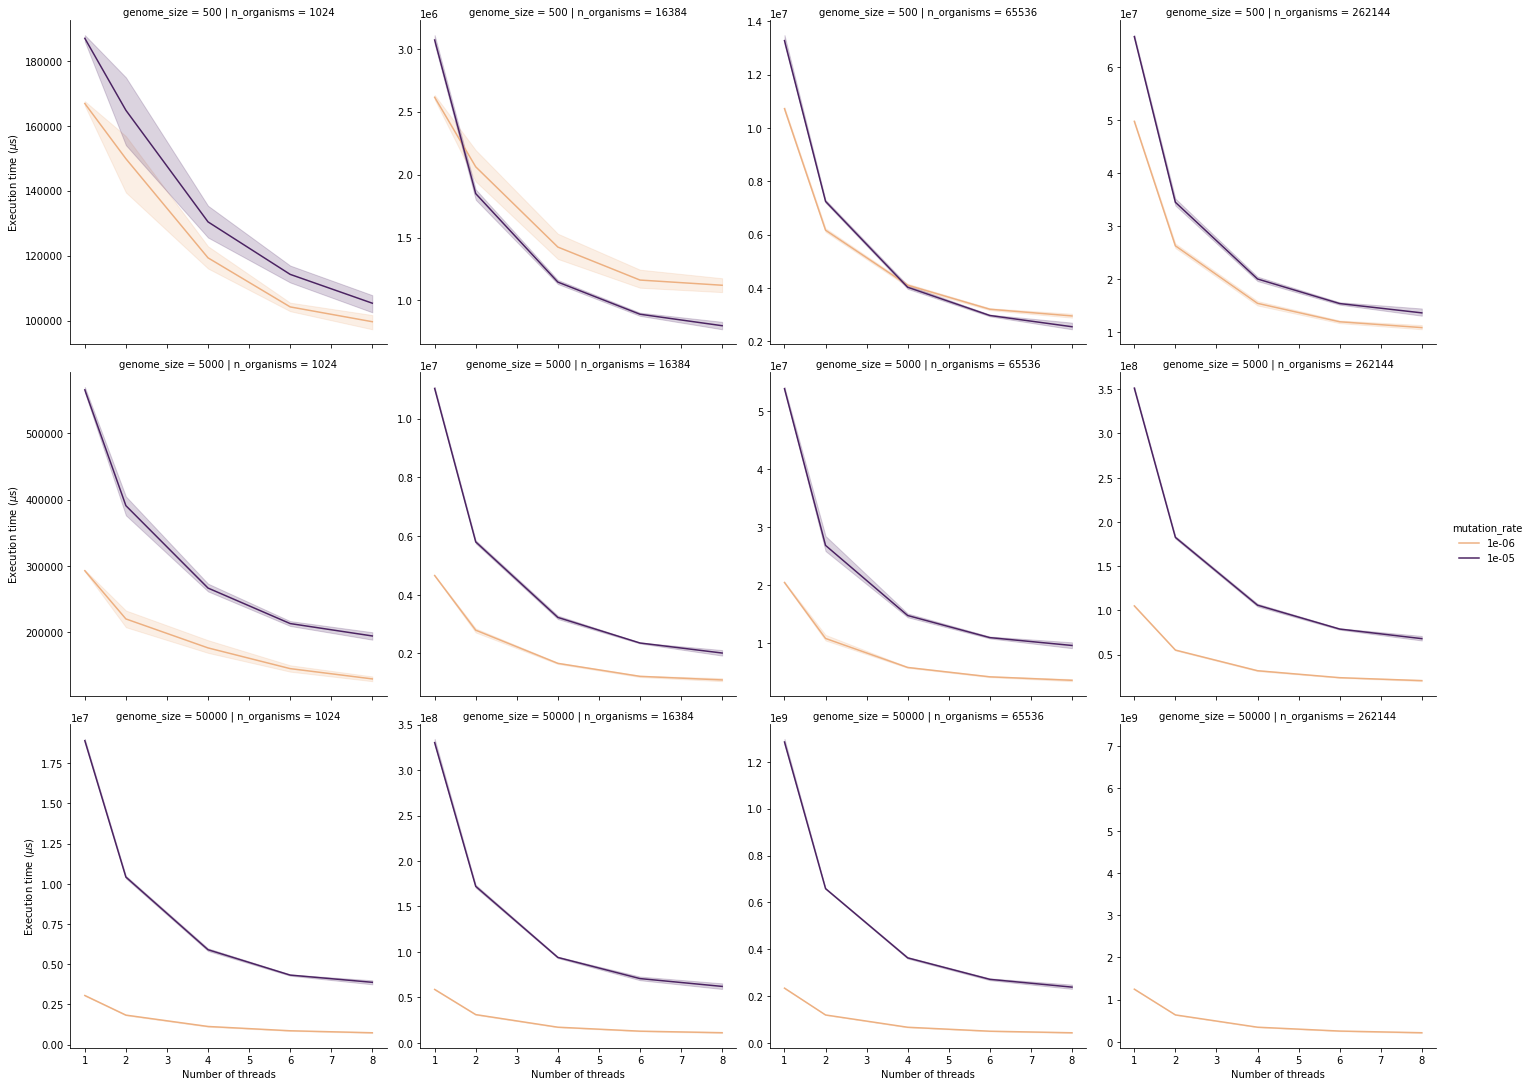

In [5]:
df_small = df[df["mutation_rate"] != 1e-4]
fig = sns.relplot(data=df_small, x="n_threads", y="time", hue="mutation_rate", col="n_organisms", kind="line", row="genome_size", legend="full", facet_kws={'sharey': False}, palette='flare')
fig.set_xlabels("Number of threads")
fig.set_ylabels("Execution time ($\mu$s)")

# fix mix of scientific and decimal notation 
for legend in fig._legend.texts:
    legend.set_text( f'{float(legend.get_text()):.0e}')

plt.show(fig)
fig.savefig('img/benchmark_omp_static_small.pdf')

# CUDA

In [6]:
N_ITERATIONS = 500
df = pd.read_csv('../benchmarks/kernel_timings_full.csv')

# taking logarithm because evaluate is so slow
df["duration_log"] = np.log(df["Duration(ns)"]) 

# do not show kernel called only once and memory transfers
df = df.groupby(by='Name').filter(lambda x: len(x) == N_ITERATIONS or len(x) == N_ITERATIONS+1)

df.sort_values(['duration_log'], ascending=False, inplace=True)

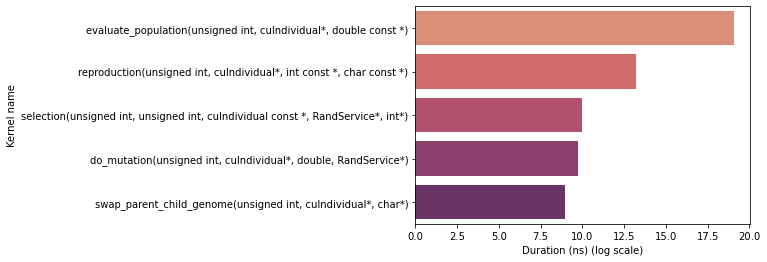

In [7]:
ax = sns.barplot(data=df, x="duration_log", y="Name", palette='flare')
ax.set_xlabel("Duration (ns) (log scale)")
ax.set_ylabel("Kernel name")

ax.get_figure().savefig('img/kernel_timings.pdf', bbox_inches='tight')

# Compression

Using data from [lzbench](https://github.com/inikep/lzbench)

In [15]:
df = pd.read_csv("../benchmarks/compression.csv")
df["log_compression_speed"] = np.log(df["compression_speed"])
df = df[df["name"].str.contains("zlib|lz4|zstd")]
df.sort_values("compression_speed", ascending=False)

,name,options,compression_speed,decompression_speed,compression_size,compression_ratio,log_compression_speed
180,lz4fast 1.9.2,-17.0,1201.00,4632,131732802.0,62.15,7.090910
174,lz4fast 1.9.2,-3.0,838.00,4423,107066190.0,50.52,6.731018
157,lz4 1.9.2,NaN,737.00,4448,100880800.0,47.60,6.602588
75,zstd 1.4.3,-1.0,480.00,1203,73508823.0,34.68,6.173786
62,zstd 1.4.3,-2.0,356.00,1067,69594511.0,32.84,5.874931
152,slz_zlib 1.0.0,-1.0,301.00,380,99657958.0,47.02,5.707110
146,slz_zlib 1.0.0,-2.0,297.00,378,96863094.0,45.70,5.693732
144,slz_zlib 1.0.0,-3.0,293.00,379,96187780.0,45.38,5.680173
116,lz4hc 1.9.2,-1.0,131.00,4071,83803769.0,39.54,4.875197
95,zlib 1.2.11,-1.0,119.00,383,77259029.0,36.45,4.779123


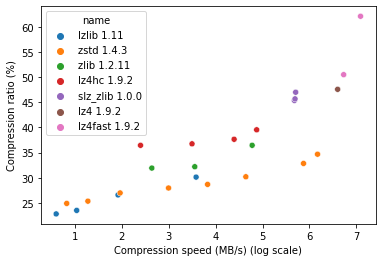

In [10]:
ax = sns.scatterplot(data=df, x="log_compression_speed", y="compression_ratio", hue="name")
ax.set_xlabel("Compression speed (MB/s) (log scale)")
ax.set_ylabel("Compression ratio (%)")

ax.get_figure().savefig("img/compression_tools.pdf", bbox_inches='tight')